In [62]:
import spacy
import pandas as pd
import re
import nltk
import string

from scipy.sparse import hstack,csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ackl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
df = pd.read_csv("../data/fraud/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [69]:
# Subsample data
df = df.fillna(' ')
fake=df[df['fraudulent']==1]
real=df[df['fraudulent']==0]

fake=fake.sample(17014,replace=True)

data_df = pd.concat([fake, real], ignore_index=True)
data_df = data_df.reset_index()

In [ ]:
# text_columns = [
#     'title', 
#     'location', 
#     'salary_range',
#     'company_profile',
#     'description',
#     'requirements',
#     # 'benefits',
#     # 'employment_type',
#     # 'required_experience',
#     # 'required_education',
#     # 'industry',
#     # 'function',
#     # 'department'
# ]
# data_df[text_columns] = data_df[text_columns].astype(str)

# data_df['text'] = data_df[text_columns].agg(' '.join, axis=1)

# data_df.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,17680,Home Based Payroll Typist/Data Entry Clerks Po...,"US, WA, Aberdeen",Clerical,nan,nan,We have several openings available in this are...,"Basic computer and typing skills, ability to s...",All you need is access to the Internet and you...,0,0,0,NaN,NaN,NaN,NaN,NaN,1,Home Based Payroll Typist/Data Entry Clerks Po...
1,1,3346,customer service representative,"US, CA, san jose",admin,13-20,nan,What we're looking for:Do you like helping oth...,"The right candidate will:- Be upbeat, person...","Benefit includes: health and welfare coverage,...",0,0,0,Full-time,Entry level,High School or equivalent,Accounting,Customer Service,1,"customer service representative US, CA, san jo..."
2,2,5506,Home Based Payroll Data Entry Clerk Position -...,"US, SC, Abbeville",NaN,nan,nan,We are a full-service marketing and staffing f...,RequirementsAll you need is access to the Inte...,This is an entry level position and we offer f...,0,0,0,NaN,NaN,NaN,NaN,NaN,1,Home Based Payroll Data Entry Clerk Position -...
3,3,3327,Customer Assistant,"CA, AB,",NaN,nan,nan,Job Description: We are looking for customer a...,Skills/Qualifications:- Post-secondary educati...,NaN,1,0,0,NaN,NaN,NaN,NaN,NaN,1,"Customer Assistant CA, AB, nan nan Job Descri..."
4,4,7482,Professional Development Coordinator (Perioper...,"US, CT,",NaN,nan,nan,Apply using below link#URL_ad7066040069336a9ba...,nan,NaN,0,0,0,Full-time,NaN,NaN,Hospital & Health Care,NaN,1,Professional Development Coordinator (Perioper...


In [70]:
def format_data(df):
    mapping = {0:False, 1:True}
    df['telecommuting'] = df['telecommuting'].map(mapping)
    df['has_company_logo'] = df['has_company_logo'].map(mapping)
    df['has_questions'] = df['has_questions'].map(mapping)
    df = df.fillna('Not Available')
    df['fraudulent'] = df['fraudulent'].map(mapping)
    return df

def concat_text(row):
    label_map = {0: "No", 1: "Yes"}
    
    # Safely get and truncate company_profile (handle NaN and non-string)
    company_profile = row.get('company_profile', '')
    if not isinstance(company_profile, str):
        company_profile = '' if pd.isna(company_profile) else str(company_profile)
    company_profile = company_profile[:300]
    
    # Safely get other fields
    title = row.get('title', '')
    job_id = row.get('job_id', '')
    description = row.get('description', '')
    requirements = row.get('requirements', '')
    location = row.get('location', '')
    
    # Handle telecommuting and fraudulent fields
    telecommuting = label_map.get(row.get('telecommuting', 0), 'No')
    
    text = f"""{title} Company: {company_profile}
    Job Id: {job_id}
    Description: {description}
    Requirements: {requirements}
    Location: {location}
    Telecommuting: {telecommuting}
    """
    return text
data_df = format_data(data_df)
data_df['text'] = data_df.apply(concat_text, axis=1)
data_df.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,17571,work from home,"US, FL, tampa",,,,MCA Associates receive $80.00 (EIGHTY DOLLARS)...,"$40 to start, computer,","• ERS, “Emergency Road Service” 24-Hour Dispat...",False,True,False,,,,,,True,work from home Company: \n Job Id: 17571\n...
1,1,17635,URGENT Part Timers & Full Timers Required.,"AU, NSW, Sydney",,,,URGENT Part Timers &amp; Full Timers Required....,,,False,False,False,Part-time,,,,,True,URGENT Part Timers & Full Timers Required. Com...
2,2,17594,Data Entry Admin/Clerical Positions - Work Fro...,"US, KS, Salina",,,,ACCEPTING ONLINE APPLICATIONS ONLYClick Here T...,,,False,False,False,,,,,,True,Data Entry Admin/Clerical Positions - Work Fro...
3,3,7659,Admin Clerical Data Processor,"US, TX, Houston",,,,We are seeking individuals to be connected wit...,Home Office SuppliesComputer with internet acc...,,True,False,False,,Entry level,Some High School Coursework,,Administrative,True,Admin Clerical Data Processor Company: \n ...
4,4,17575,Data Entry Admin/Clerical Positions - Work Fro...,"US, SD, Yankton",,,,ACCEPTING ONLINE APPLICATIONS ONLYClick Here T...,,,False,False,False,,,,,,True,Data Entry Admin/Clerical Positions - Work Fro...


# Text Cleaning

In [71]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',str(text))

def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def final_preprocess(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
    text = text.lower()
    ps = PorterStemmer()
    text = ps.stem(text)
    return text

def preprocess_text(text):
    text = remove_URL(text)
    text = remove_emoji(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = final_preprocess(text)
    return text

In [72]:
clean_data = data_df['text'].apply(preprocess_text)
clean_data.head()

0    work home company job id 17571 description mca...
1    urgent part timers full timers required compan...
2    data entry adminclerical positions work home c...
3    admin clerical data processor company job id 7...
4    data entry adminclerical positions work home c...
Name: text, dtype: object

In [49]:
type(clean_data)

pandas.core.series.Series

# Text Tokenization

In [73]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
vectorizer = CountVectorizer(ngram_range=(1, 2))

In [74]:
# def lemma_pos_text(text):
#     doc = nlp(str(text))
#     lemmas = [token.lemma_ for token in doc]
#     pos_tags = [token.pos_ for token in doc]
    
#     lemmatized_text = ' '.join(lemmas)
#     pos_text = ' '.join(pos_tags)
    
#     return lemmatized_text, pos_text


def lemmatize_and_tag_pipe(docs):
    for doc in docs:
        lemmas = [token.lemma_ for token in doc]
        pos_tags = [token.pos_ for token in doc]
        yield ' '.join(lemmas), ' '.join(pos_tags)


In [75]:
def process_series_with_pipe(text_series):
    docs = nlp.pipe(text_series.astype(str), batch_size=1000)
    results = [(
        ' '.join([token.lemma_ for token in doc]),
        ' '.join([token.pos_ for token in doc])
    ) for doc in docs]
    # Convert results to a DataFrame for easy assignment
    return pd.DataFrame(results, columns=["lemmatized_text", "pos_tags"], index=text_series.index)

In [76]:
result_df = process_series_with_pipe(clean_data)

In [77]:
result_df.head()

,lemmatized_text,pos_tags
0,work home company job i d 17571 description mc...,VERB NOUN NOUN NOUN NOUN PROPN NUM NOUN PROPN ...
1,urgent part timer full timer require company j...,ADJ NOUN NOUN ADJ NOUN VERB NOUN NOUN NOUN NOU...
2,datum entry adminclerical position work home c...,NOUN NOUN ADJ NOUN VERB NOUN NOUN NOUN NOUN PR...
3,admin clerical datum processor company job i d...,VERB ADJ NOUN NOUN NOUN NOUN NOUN PROPN NUM NO...
4,datum entry adminclerical position work home c...,NOUN NOUN ADJ NOUN VERB NOUN NOUN NOUN NOUN PR...


In [78]:
text_matrix_train = vectorizer.fit_transform(result_df['lemmatized_text'])

pos_matrix_train = vectorizer.transform(result_df['pos_tags'])

combined_matrix_train = hstack([text_matrix_train, pos_matrix_train])

In [79]:
import pickle

with open('countvectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Model Training

In [80]:
X = combined_matrix_train
y = data_df['fraudulent'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [67]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score,
                             recall_score, 
                             f1_score, 
                             confusion_matrix,
                             precision_score,
)
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

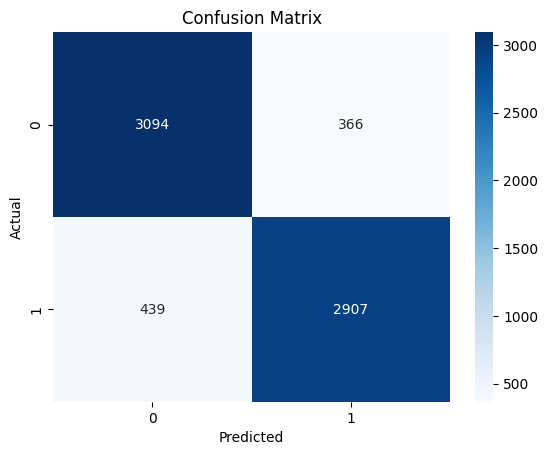

Cross-validation scores: [0.88099174 0.87254362 0.87986774 0.87711242 0.88023512]
Average cross-validation score: 0.8781501272831178
Test set accuracy: 0.8817220099911842
Test set precision: 0.8881759853345554
Test set recall: 0.8687985654512851
Test set F1 score: 0.8783804200030216


In [82]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=5)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)

In [83]:
with open('fraud_clf_decision_tree.pkl', 'wb') as f:
    pickle.dump(model, f)